In [1]:
from datetime import datetime, timedelta
import pickle
import copy

from package.query import *
from package.plot import *
from package.data_mgt import *
from package.seriealize import *
from package.dic_mgt import *

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34963, 35429, 35512, 35730, 36235, 36503, 36809', '34128, 33769, 33928, 34336, 34347, 34545', '34783, 34686, 34729, 34870, 34965, 35058, 35101', '34963, 35212, 35072, 34932, 35253, 35514, 35374', '34696, 34674, 34764, 34850, 34918, 34937, 35012', '34566, 34411, 34599, 35044, 34994, 35159, 35084', '34681, 34759, 34822, 34891, 34989, 35103, 35194', '34609, 34548, 34393, 34242, 34167, 34024, 33968', '34589, 34771, 35163, 35240, 35432, 35621, 35948', '34765, 34924, 34832, 34976, 35087, 35012, 35191']
serialized list :  [[34963, 35429, 35512, 35730, 36235, 36503, 36809], [34128, 33769, 33928, 34336, 34347, 34545, 34545], [34783, 34686, 34729, 34870, 34965, 35058, 35101], [34963, 35212, 35072, 34932, 35253, 35514, 35374], [34696, 34674, 34764, 34850, 34918, 34937, 35012], [34566, 34411, 34599, 35044, 34994, 35159, 35084], [34681, 34759, 34822, 34891, 34989, 35103, 35194], [34609, 34548, 34393, 34242, 34167, 34024, 33968]

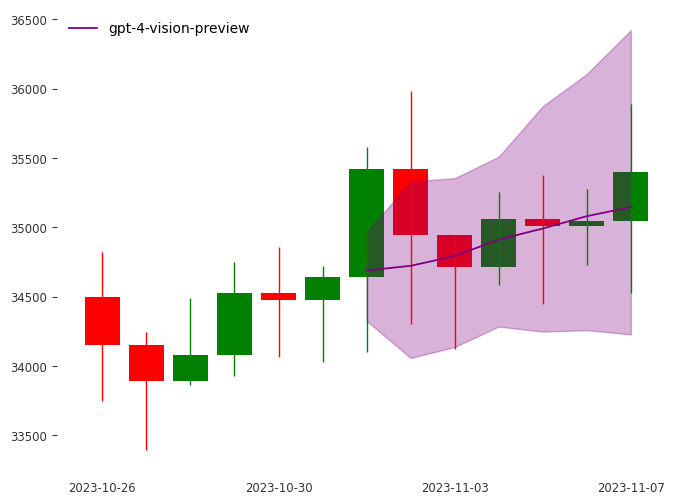

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34805, 35228, 35341, 35805, 36030, 36405, 36569', '34590, 34722, 34666, 34795, 34734, 34860, 34804', '34971, 35176, 35394, 35501, 35920, 36143, 36234', '34610, 34739, 34921, 35138, 35214, 35305, 35411', '34601, 34666, 34626, 34691, 34651, 34716, 34676', '34717, 34768, 34778, 34743, 34720, 34704, 34697', '34562, 34505, 34583, 34534, 34557, 34548, 34553', '34690, 34915, 35019, 35524, 36254, 36811, 37139', '34599, 34672, 34649, 34715, 34679, 34728, 34705', '34722, 34889, 34839, 35004, 35084, 35251, 35201']
serialized list :  [[34805, 35228, 35341, 35805, 36030, 36405, 36569], [34590, 34722, 34666, 34795, 34734, 34860, 34804], [34971, 35176, 35394, 35501, 35920, 36143, 36234], [34610, 34739, 34921, 35138, 35214, 35305, 35411], [34601, 34666, 34626, 34691, 34651, 34716, 34676], [34717, 34768, 34778, 34743, 34720, 34704, 34697], [34562, 34505, 34583, 34534, 34557, 34548, 34553], 

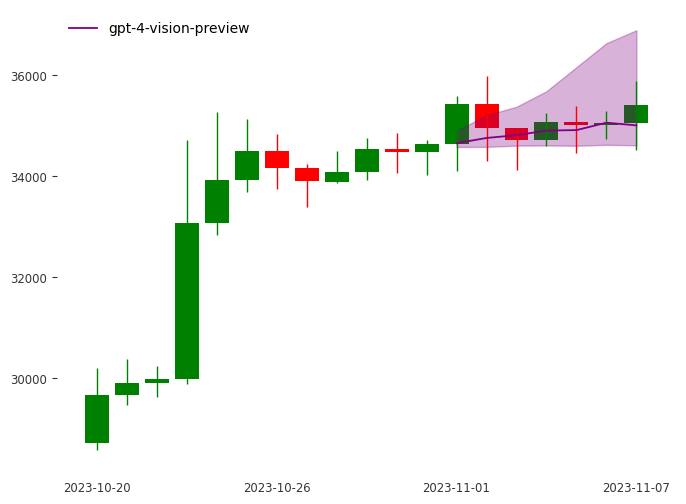

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34677, 34504, 34338, 34072, 34407, 34347, 34271', '35220, 36161, 37206, 38283, 39104, 39956, 40832', '34755, 35037, 35521, 35872, 36314, 36679, 37160', '34592, 34638, 34771, 34905, 35030, 35149, 35256', '34618, 34570, 34522, 34474, 34426, 34378, 34330', '34808, 35681, 36676, 37099, 37020, 37181, 37345', '34718, 34668, 34697, 34736, 34705, 34770, 34739', '34404, 34045, 33740, 33605, 33322, 33041, 32906', '34705, 34922, 34999, 35319, 35498, 35566, 35677', '34678, 34715, 34752, 34789, 34826, 34863, 34900']
serialized list :  [[34677, 34504, 34338, 34072, 34407, 34347, 34271], [35220, 36161, 37206, 38283, 39104, 39956, 40832], [34755, 35037, 35521, 35872, 36314, 36679, 37160], [34592, 34638, 34771, 34905, 35030, 35149, 35256], [34618, 34570, 34522, 34474, 34426, 34378, 34330], [34808, 35681, 366

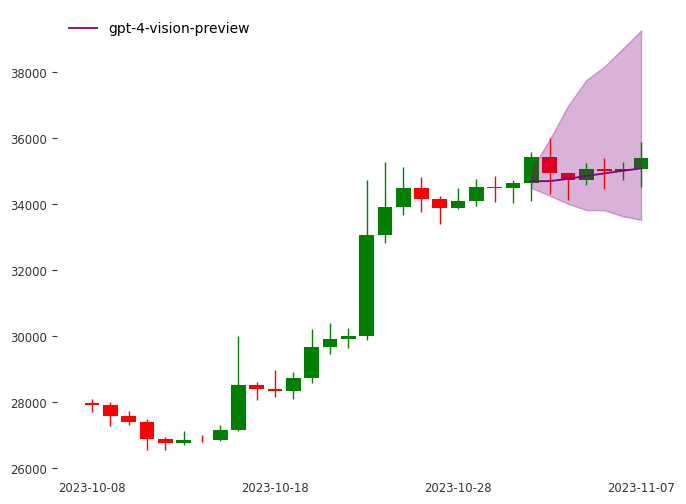

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34682, 34742, 34875, 34912, 34948, 35019, 35057', '34525, 34242, 34006, 33657, 33431, 33221, 33040', '34570, 34579, 34568, 34620, 34715, 34740, 34762', '34804, 34729, 34793, 35231, 35156, 35120, 35043', '34718, 35002, 35113, 35231, 35294, 35421, 35538', '34636, 34621, 34597, 34584, 34572, 34561, 34553', '34796, 34975, 35006, 35000, 34972, 34948, 34931', '34372, 34289, 34226, 34255, 33967, 33884, 33821', '34668, 34905, 34749, 33695, 33508, 33449, 33723', '34605, 34566, 35022, 35232, 35299, 35533, 35672']
serialized list :  [[34682, 34742, 34875, 34912, 34948, 35019, 35057], [34525, 34242, 34006, 33657, 33431, 33221, 33040], [34

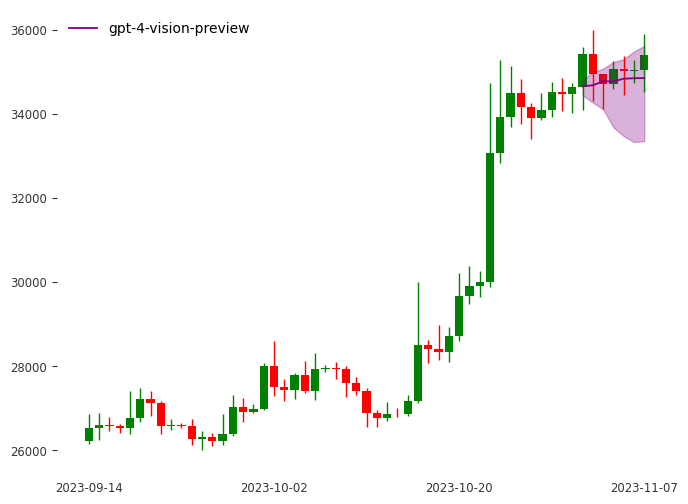

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34632, 34564, 34597, 34540, 34429, 34519, 34520', '34589, 34715, 34670, 34803, 35050, 35110, 35131', '34612, 34518, 34588, 34453, 34531, 34354, 34317', '34607, 34589, 34462, 34406, 34455, 34688, 34719', '34771, 35103, 36358, 36507, 36305, 36852, 37714', '34600, 34559, 34419, 34378, 34237, 34196, 3

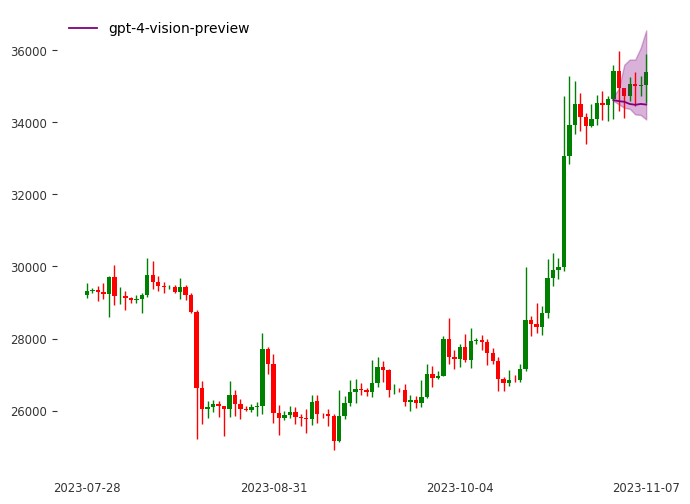

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

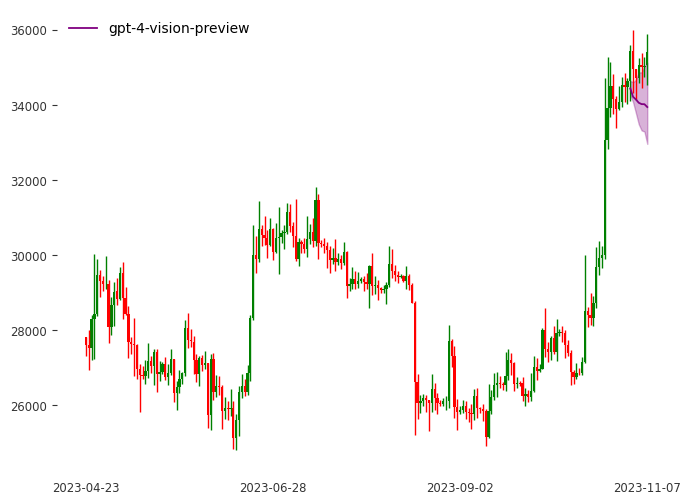

In [2]:
make_prediction(mode = "naive", data = "bitcoin", setup = None, model = "gpt-4-vision-preview")

In [5]:
all_naive_dic = make_dic_MAE_MSE("naive")

{'input_length': {6: {'Mae': [[459.13113246215653, 487.5613064233694, 794.879542611663, 666.9447514835265, 1222.0535351700019, 1457.096726418742, 1409.2234133746533], [1294.1311324621565, 1172.4386935766306, 789.120457388337, 727.0552485164735, 665.9464648299981, 500.90327358125796, 854.7765866253467], [639.1311324621565, 255.4386935766306, 11.879542611663055, 193.0552485164735, 47.94646482999815, 12.096726418742037, 298.7765866253467], [459.13113246215653, 270.5613064233694, 354.87954261166306, 131.0552485164735, 240.05353517000185, 468.09672641874204, 25.77658662534668], [726.1311324621565, 267.4386935766306, 46.879542611663055, 213.0552485164735, 94.94646482999815, 108.90327358125796, 387.7765866253467], [856.1311324621565, 530.4386935766306, 118.12045738833694, 19.05524851647351, 18.94646482999815, 113.09672641874204, 315.7765866253467], [741.1311324621565, 182.4386935766306, 104.87954261166306, 172.0552485164735, 23.94646482999815, 57.09672641874204, 205.77658662534668], [813.1311

In [7]:
display_tab(all_naive_dic)

Global MAE/MSE
  input_length      Mae     Mse
--------------  -------  ------
             6  477.715  338247
            12  395.49   239411
            24  627.428  688259
            48  450.823  294506
            96  486.026  350497
           192  717.297  605787
  input_length      Mae               Mse
--------------  -------  ----------------
             6  423.834  297343
            12  412.756  258336
            24  804.419       1.31874e+06
            48  488.714  404121
            96  543.118  403816
           192  812.818  833068
  input_length      Mae               Mse
--------------  -------  ----------------
             6  446.093  347965
            12  493.048  392880
            24  982.35        2.12042e+06
            48  565      581616
            96  639.922  584688
           192  930.184       1.15752e+06
##############################
Median MAE/MSE
  input_length      Mae     Mse
--------------  -------  ------
             6  342.816  197302
     

Input str :  -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['89, -83, 131, 136, -42, 142, 190', '100, 29, -190, -19, 330, 110, -485', '172, 123, 353, 231, 628, 433, 1096', '95, 95, 95, 95, 95, 95, 95', '88, 19, -60, -109, 36, -3, -42', '-29, 105, 160, -71, 92, -109, 50', '130, 241, 148, 345, 244, 488, 463', '86, -108, -45, 223, 143, -292, -172', '113, 178, 42, 105, 240, 75, 210', '112, 179, 30, 89, 160, 213, 82']
int list return
[[89, -83, 131, 136, -42, 142, 190], [100, 29, -190, -19, 330, 110, -485], [172, 123, 353, 231, 628, 433, 1096], [95, 95, 95, 95, 95, 95, 95], [88, 19, -60, -109, 36, -3, -42], [-29, 105, 160, -71, 92, -109, 50], [130, 241, 148, 345, 244, 488, 463], [86, -108, -45, 223, 143, -292, -172], [113, 178, 42, 105, 240, 75, 210], [112, 179, 30, 89, 160, 213, 82]]
int list, close
[[34949.04132031571, 34658.96427735709, 35112.99670939047, 35590.53346463818, 35441.0532240867, 35944.316179868736, 36627.258187286236], [34987.14613293574, 35088.60885672125, 34421.92528844355, 

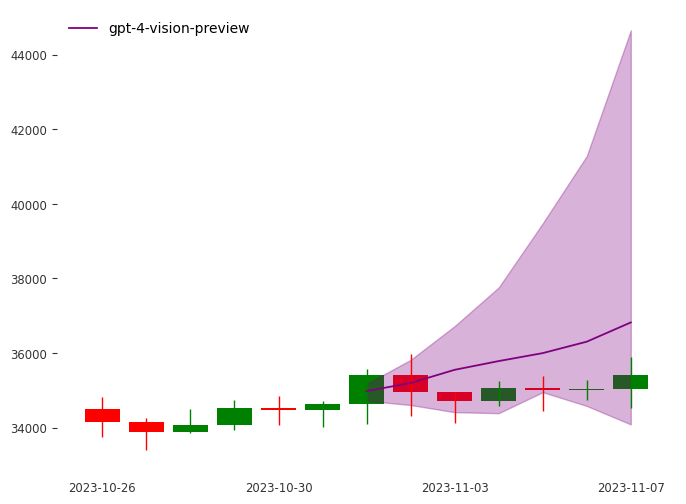

Input str :  333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['3, -23, -166, 207, -308', '-121, -37, 140, 203, -227, -109, 224', '-32, 24, -8, 6, -2, 1, 0', '-59, 33, -43, 28, -27', '-132, 205, -168, 594, 148, 104, -342', '57, -9, -5, 66, 15, 41, -36', '-37, 92, -67, 216, -119', '-25, 29, -39, 24, -55, 21, -73', '-19, 50, -23, 52, -27, 54, -31', '-503, 66, 149, -31, 40, -299, 56']
int list return
[[3, -23, -166, 207, -308, -308, -308], [-121, -37, 140, 203, -227, -109, 224], [-32, 24, -8, 6, -2, 1, 0], [-59, 33, -43, 28, -27, -27, -27], [-132, 205, -168, 594, 148, 104, -342], [57, -9, -5, 66, 15, 41, -36], [-37, 92, -67, 216, -119, -119, -119], [-25, 29, -39, 24, -55, 21, -73], [-19, 50, -23, 52, -27, 54, -31], [-503, 66, 149, -31, 40, -299, 56]]
int list, close
[[34651.130967104575, 34571.433365880235, 33997.547572006624, 34701.29680674716, 33632.49686509935, 32596.615961654286, 31592.640190035334], [34221.58580666061, 34094.96593917596, 34572.29546232443, 352

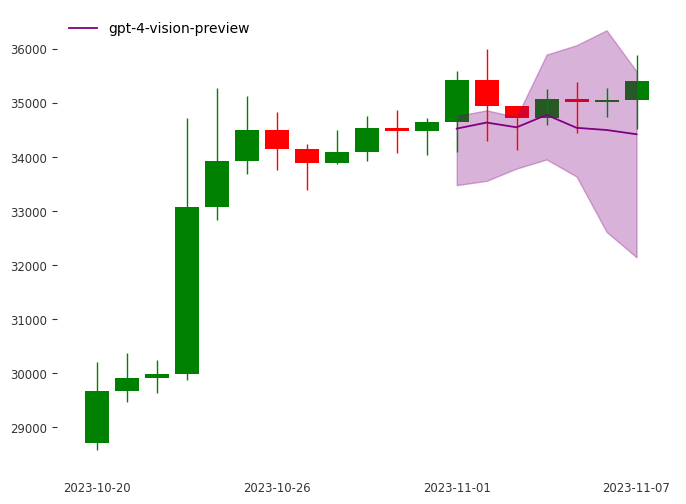

Input str :  -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['235, 422, 606, 809, 1032, 1276, 1541', '75, -203, -175, -50, 25, 175, 546', '217, 212, 207, 202, 197, 192, 187', '93, 150, -19, -7, 181, 263, 109', '71, -103, -7, 159, 276, 194, 268', '225, 304, -144, -243, 369, 1792, 217', '219, 70, -49, -109, -22, 180, 380', '93, -144, 17, -42, 24, 63, -12', '-77, 73, -117, 62, -108, 152, -8', '204, -37, 23, 165, 423, 71, 35']
int list return
[[235, 422, 606, 809, 1032, 1276, 1541], [75, -203, -175, -50, 25, 175, 546], [217, 212, 207, 202, 197, 192, 187], [93, 150, -19, -7, 181, 263, 109], [71, -103, -7, 159, 276, 194, 268], [225, 304, -144, -243, 369, 1792, 217], [219, 70, -49, -109, -22, 180, 380], [93, -144, 17, -42, 24, 63, -12], [-77, 73, -117, 62, -108, 152, -8], [204, -37, 23, 165, 423, 71, 35]]
int list, close
[[35454.79610599973, 36950.988501672924, 39190.2184048743, 42360.70707382863, 46732.3320

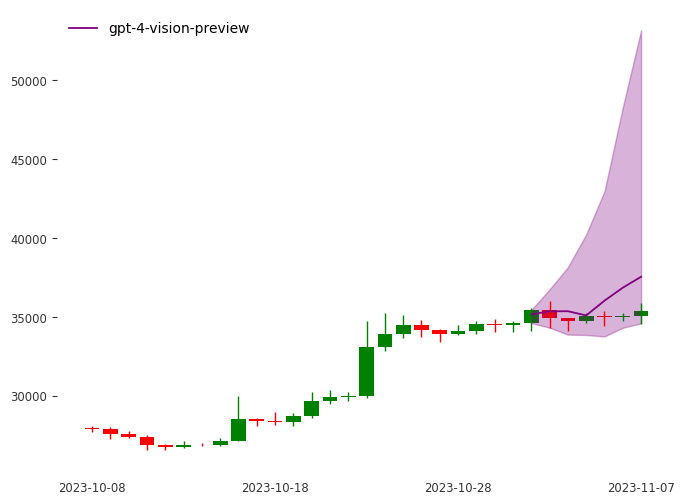

Input str :  115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-8, -60, 87, 70, 202, 52, 27', '-10, -60, -80, 76, 89, -8, 160', '621, -37, -7, 72, 279, 662, 36', '42, -11, -66, 156, 367, 684, 315', '-87, -213, -98, -29, 57, 184, 276', '-98, 202, 197, 84, 205, -25, 243', '-49, -13, 187, 287, 109, -61, 59', '-159, -9, 209, 60, 198, 1091, 326', '272, -49, -191, 172, -47, -24, 54', '-128, -122, -137, -53, 13, 74, 209']
int list return
[[-8, -60, 87, 70, 202, 52, 27], [-10, -60, -80, 76, 89, -8, 160], [621, -37, -7, 72, 279, 662, 36], [42, -11, -66, 156, 367, 684, 315], [-87, -213, -98, -29, 57, 184, 276], [-98, 202, 197, 84, 205, -25, 243], [-49, -13, 187, 287, 109, -61, 59], [-159, -9, 209, 60, 198, 1091, 326], [272, -49, -191, 172, -47, -24, 54], [-128, -122, -137, -53, 13, 74, 209]]
int list

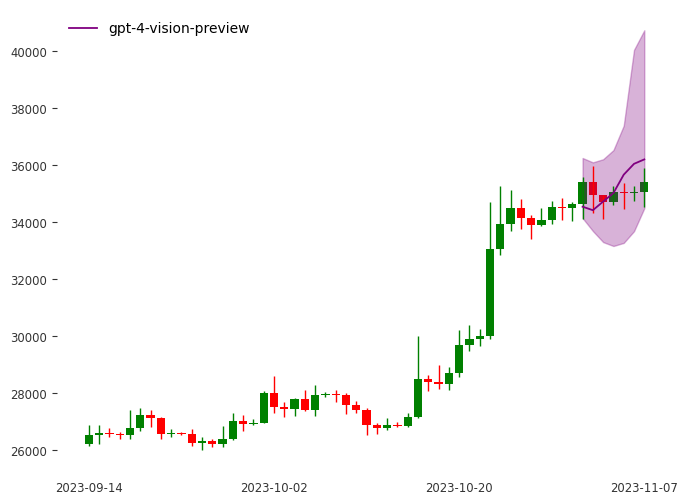

Input str :  31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-475, -113, 84, 147, -82, -7, 6', '-36, -12, 4, 61, 217, 47, -84', '-453, 102, 152, -71, -58, 36, 99', '-53, -497, -27, 95, 54, 180, -179', '-210, -25, -28, 62, 63, 236, 109', '-193, -176, 75, 49, 43, -29, -78', '-62, -77, 193, -155, -58, 43, -213', '-64, -63, -21, 43, -226, 234, 197', '-10, -3, -22, -45, -717, -172, -25', '365, 205, -778, -84, 60, -18, -117']
int list return
[[-475, -113, 84, 147, -82, -7, 6], [-36, -12, 4, 61, 217, 47, -84], [-453, 102, 152, -71, -58, 36, 99], [-53, -497, -27, 95, 54,

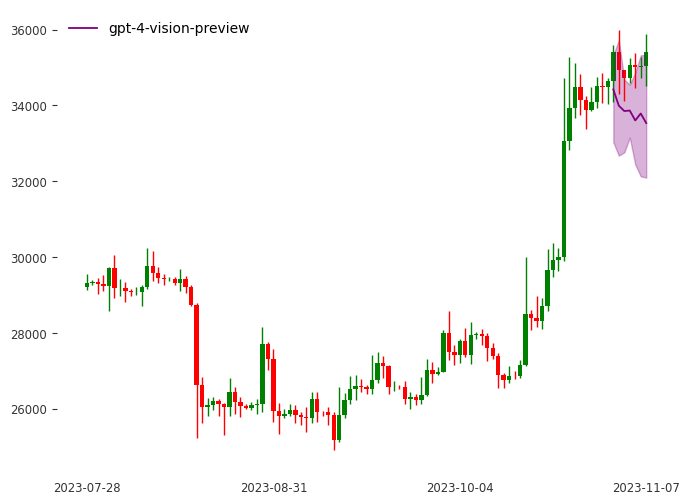

Input str :  -81, -29, 287, 41, 372, -55, -28, 1, -399, 214, 124, -65, 232, -222, -145, -268, -15, -11, -228, -64, -8, 53, 91, -47, 137, -213, 22, 83, -131, 38, 138, -327, 55, 88, 56, 451, -117, -15, -175, -144, 158, -64, 17, -511, 584, -327, 61, -8, -240, 33, -8, 11, -311, 187, 292, 65, -67, 192, 545, 596, -37, 269, -52, -21, -64, 140, -200, 123, 8, 37, 10, 176, -125, -85, -199, 150, -20, -41, 83, 69, -79, 354, -363, -7, -19, -31, -92, 17, -37, 34, -36, 97, -302, 18, 42, -44, 31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-69, 153, -118, 19, 33, -16, 189', '-39

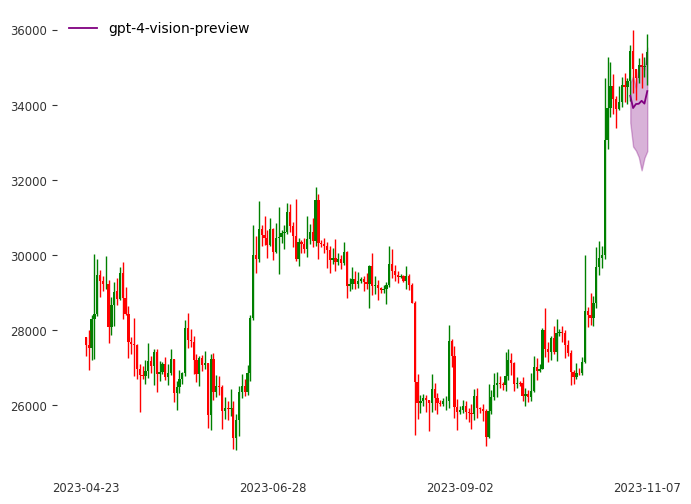

In [2]:
make_prediction(mode = "return", data = "bitcoin_return", setup = None, model = "gpt-4-vision-preview")

In [3]:
all_return_dic = make_dic_MAE_MSE("return")

dic_error :
{'input_length': {6: {'Mae': [[473.0898121464488, 282.47441621954204, 395.8762520021337, 527.4782161217081, 428.1067592567051, 898.4129062874781, 1227.481600660889], [434.9849995264158, 147.17016314461944, 295.19516894478875, 706.531618120971, 477.3424453685511, 834.7788146294697, 1259.3075796928388], [185.57168055895454, 728.5304395849817, 2211.998586173875, 2719.126444952024, 5141.956238988321, 6847.706717312387, 11085.373059270241], [452.30536889915675, 360.60041474022, 920.2880224575274, 912.9086118879277, 1304.7890522482485, 1616.850730909231, 1611.2735809078076], [476.5538860209999, 70.53514963276393, 84.7815427618043, 640.493980167972, 466.4639759154379, 509.78472941336804, 1008.709740342958], [881.8505293431226, 38.485144124846556, 744.2803488546779, 146.5696120022185, 520.6069444054665, 100.33440349353623, 77.80772116518347], [331.06278328997723, 995.3244028105983, 1751.5067328254227, 2663.739579759662, 3634.3821572560773, 5487.414985262614, 7010.234307602994], [48

In [4]:
display_tab(all_return_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   592.778  573957
            12   621.548  702353
            24   780.472       1.3743e+06
            48   794.899  910929
            96  1148.89        1.75805e+06
           192  1057.52        1.43695e+06
Mean error with 5 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   893.308       1.71192e+06
            12   625.175  693789
            24  1227.12        5.34466e+06
            48   904.363       1.2527e+06
            96  1215.12        1.90297e+06
           192  1128.56        1.72367e+06
Mean error with 7 days forecasting
  input_length       Mae          Mse
--------------  --------  -----------
             6  1367.81   5.30776e+06
            12   780.996  1.15697e+06
            24  2118.78   2.0406e+07
            48  1237.83   3.15555e+06
       

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, U4, U4, U2, D2, U2', 'D2, U2, U2, D2, U2, U2, U2', 'D2, U2, D2, U4, D4, U6, D8', 'D2, U2, U2, U4, D2, U2, U2', 'U2, U2, U2, U2, U2, U2, U2', 'D2, U2, D4, U2, D2, U4, U2', 'U2, U2, U4, U4, U6, U8, U10', 'D2, U2, D2, U2, D2, U2, D2', 'D2, U2, U2, D2, U2, U2, D2', 'D2, U2, U2, D2, D2, U2, U2']
serialized :  [[-1, 1, 3, 3, 1, -1, 1], [-1, 1, 1, -1, 1, 1, 1], [-1, 1, -1, 3, -3, 5, -7], [-1, 1, 1, 3, -1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [-1, 1, -3, 1, -1, 3, 1], [1, 1, 3, 3, 5, 7, 9], [-1, 1, -1, 1, -1, 1, -1], [-1, 1, 1, -1, 1, 1, -1], [-1, 1, 1, -1, -1, 1, 1]]
int list, close
[[34294, 34636, 35675, 36745, 37112, 36740, 37107], [34294, 34636, 34982, 34632, 34978, 35327, 35680], [34294, 34636, 34289, 35317, 34257, 35969, 33451], [34294, 34636, 34982, 36031, 35670, 36026, 36386], [34987, 35336, 35689, 36045, 36405, 36769, 37136], [34294, 34636, 33596, 33931, 33591, 34598, 34943], [34987, 35336, 36396, 37487, 39361, 4

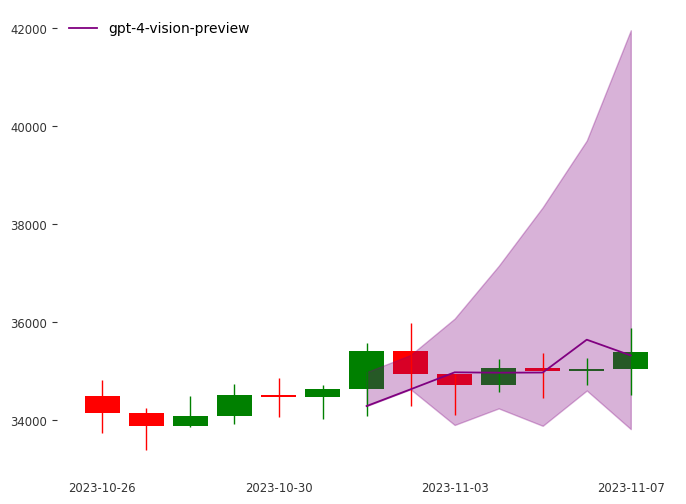

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, U2, U2, U2, U2, U2', 'U2, U2, D2, D2, D4, D4, D6', 'To continue the given sequence, I first need to understand the pattern of the changes in terms of the provided bins. Let\'s look at the percentage changes and map them to the bins:\n\n1. 29670 to 29910: This is an increase of about 0.81%, which falls into the "U2" bin.\n2. 29910 to 29993: This is an increase of about 0.28%, which falls into the "U2" bin.\n3. 29993 to 33070: This is an increase of about 10.26%, which falls into the "U10+" bin.\n4. 33070 to 33922: This is an increase of about 2.58%, which falls into the "U4" bin.\n5. 33922 to 34496: This is an increase of about 1.69%, which falls into the "U2" bin.\n6. 34496 to 34152: This is a decrease of about 1%, which falls into the "D2" bin.\n7. 34152 to 33893: This is a decrease of about 0.76%, which falls into the "D2" bin.\n8. 33893 to 34081: This is an incre

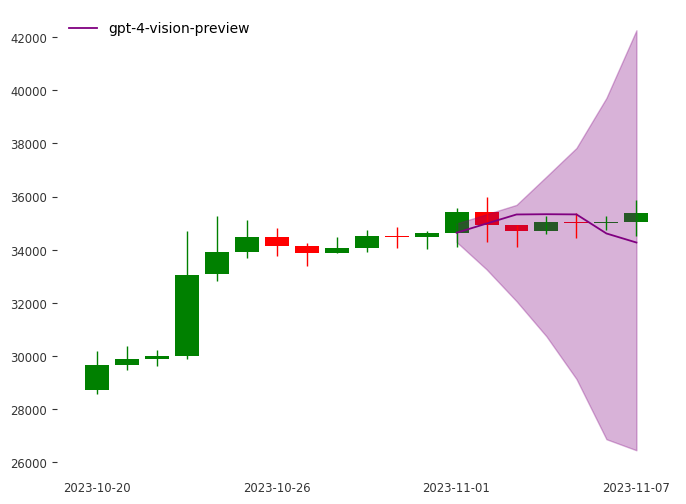

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, D2, U2, U2, U2, U2, U2', 'D2, D2, U2, D2, U2, U2, U2', 'U2, U2, D2, D2, U2, U2, U2', 'D4, D2, U2, U2, U2, U2, U4', 'D2, D2, D2, U2, U2, D2, D2', 'D2, D2, U2, D2, U2, D2, U2', 'D2, D2, U2, D2, D2, U2, U2', 'D2, D2, U2, U2, U2, U2, U2', 'D2, U2, D2, D4, D2, U2, D2', 'D2, D2, D4, D2, U2, U2, U2']
serialized :  [[-1, -1, 1, 1, 1, 1, 1], [-1, -1, 1, -1, 1, 1, 1], [1, 1, -1, -1, 1, 1, 1], [-3, -1, 1, 1, 1, 1, 3], [-1, -1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, 1, -1, 1], [-1, -1, 1, -1, -1, 1, 1], [-1, -1, 1, 1, 1, 1, 1], [-1, 1, -1, -3, -1, 1, -1], [-1, -1, -3, -1, 1, 1, 1]]
int list, close
[[34294, 33951, 34290, 34632, 34978, 35327, 35680], [34294, 33951, 34290, 33947, 34286, 34628, 34974], [34987, 35336, 34982, 34632, 34978, 35327, 35680], [33601, 33264, 33596, 33931, 34270, 34612, 35650], [342

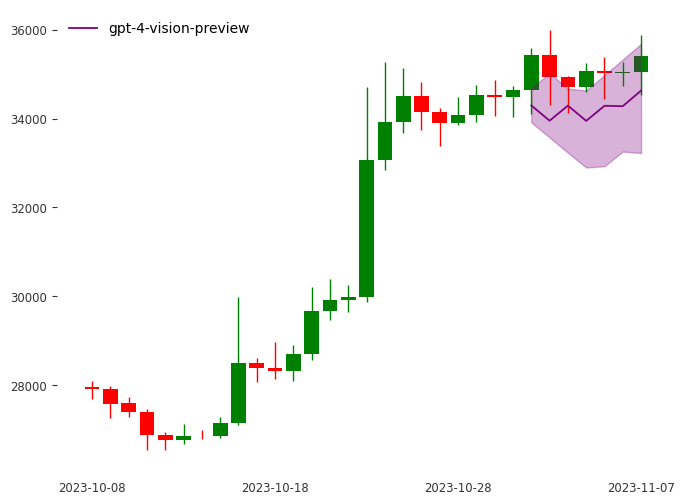

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, U2, U2, U2, U2, U2', 'U2, U2, U4, U6, U8, U10, U10+', 'D2, D4, D6, D8, D10, D10+, U2', 'U2, U2, U4, U4, U6, U8, U10', 'D2, D4, D6, D8, D10, D10+, U2', 'D2, D2, D4, D6, D8, D10, D10+', 'U2, U2, D2, D2, D4, D4, D6', 'U6, U8, U10, U10+, U10, U8, U6', 'D2, U2, U2, D2, D4, D8, D10', 'D2, D4, D6, D4, D2, U2, U4']
serialized :  [[1, 1, 1, 1, 1, 1, 1], [1, 1, 3, 5, 7, 9, 11], [-1, -3, -5, -7, -9, -11, 1], [1, 1, 3, 3, 5, 7, 9], [-1, -3, -5, -7, -9, -11, 1], [-1, -1, -3, -5, -7, -9, -11], [1, 1, -1, -1, -3, -3, -5], [5, 7, 9, 11, 9, 7, 5], [-1, 1, 1, -1, -3, -7, -9], [-1, -3, -5, -3, -1, 1, 3]]
int list, close
[[34987, 35336, 3

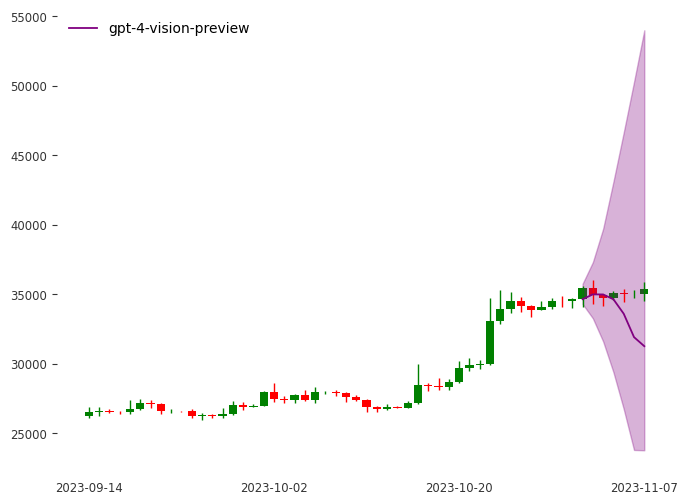

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, D2, D4, U2, D4, D6, D8', 'D2, U2, U4, U4, U6, U8, U10', 'D2, D4, D6, D8, D10, D10+, D10+', 'U10+, U10+, U10+, U10+, U10+, U8, U6', 'U10+, U10+, U10+, U10+, U10+, U10+, U10+', 'D4, D6, D8, D10, D10+, U2, U4', 'D4, D2, D2, D4, D6, D8, D10', 'U2, U2, D2, D4, D6, D8, D10', 'U10, U8, U6, U4, U2, D2

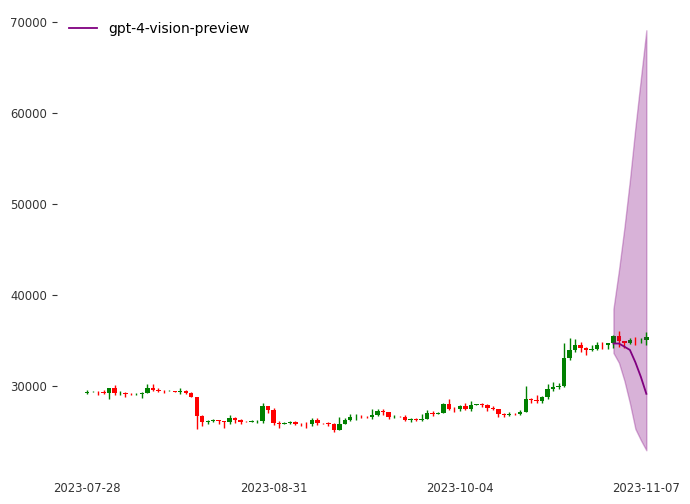

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

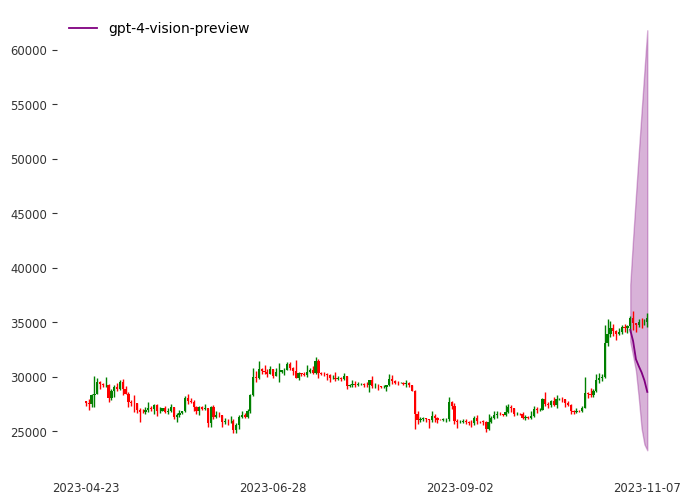

In [2]:
make_prediction(mode = "bin", data = "bitcoin", setup = None, model = "gpt-4-vision-preview")

In [3]:
all_bin_dic = make_dic_MAE_MSE("bin")

dic_error :
{'input_length': {6: {'Mae': [[1128.1311324621565, 305.4386935766306, 957.879542611663, 1681.9447514835265, 2099.053535170002, 1694.096726418742, 1707.2234133746533], [1128.1311324621565, 305.4386935766306, 264.87954261166306, 431.0552485164735, 34.94646482999815, 281.09672641874204, 280.2234133746533], [1128.1311324621565, 305.4386935766306, 428.12045738833694, 253.9447514835265, 755.9464648299981, 923.096726418742, 1948.7765866253467], [1128.1311324621565, 305.4386935766306, 264.87954261166306, 967.9447514835265, 657.0535351700019, 980.096726418742, 986.2234133746533], [435.13113246215653, 394.5613064233694, 971.879542611663, 981.9447514835265, 1392.0535351700019, 1723.096726418742, 1736.2234133746533], [1128.1311324621565, 305.4386935766306, 1121.120457388337, 1132.0552485164735, 1421.9464648299981, 447.90327358125796, 456.7765866253467], [435.13113246215653, 394.5613064233694, 1678.879542611663, 2423.9447514835265, 4348.053535170002, 7070.096726418742, 10506.22341337465

In [4]:
display_tab(all_bin_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   659.115  606756
            12   914.45        1.25277e+06
            24   914.426       1.01498e+06
            48  1463.56        4.41127e+06
            96  3134.28        2.09443e+07
           192  3173.37        1.82333e+07
Mean error with 5 days forecasting
  input_length       Mae          Mse
--------------  --------  -----------
             6   822.827  1.20473e+06
            12  1379.92   4.12636e+06
            24   943.836  1.18789e+06
            48  2815.64   1.82242e+07
            96  5063.67   5.71945e+07
           192  4878.51   4.70329e+07
Mean error with 7 days forecasting
  input_length      Mae          Mse
--------------  -------  -----------
             6  1071.1   3.45104e+06
            12  2037.22  1.07024e+07
            24   937.3   1.22382e+06
            48  4558.19  4.43441e+07
            96  7222

In [3]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "APD/"

dict_error_APD = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                130: {"Mae": None, "Mse": None}}}

dict_error_APD_median = copy.deepcopy(dict_error_APD)

for input_length in [6, 12, 24, 48, 96, 130] :

    df_raw, train, test = get_data_darts(input_length)   
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    final_dic = basic_seriealize(list_response)
    print("int list APD")
    print(final_dic)

    full_Mae_dict, full_Mse_dict = MAE_MSE_calculator(final_dic, df_raw, input_length)
    dict_error_APD["input_length"][input_length]["Mae"] = full_Mae_dict.copy()
    dict_error_APD["input_length"][input_length]["Mse"] = full_Mse_dict.copy()

    full_Mae_dict_median, full_Mse_dict_median = MAE_MSE_median_calculator(final_dic, df_raw, input_length)
    dict_error_APD_median["input_length"][input_length]["Mae"] = full_Mae_dict_median.copy()
    dict_error_APD_median["input_length"][input_length]["Mse"] = full_Mse_dict_median.copy()

    index_save += 1
    current_folder = savefig + str(index_save)
    # plot_pred_classic(df_raw, train, final_dic, "gpt-4-vision-preview",  savefig = current_folder)


with open('pickle/dic_error_APD.pkl', 'wb') as fichier:
    pickle.dump(dict_error_APD, fichier)

with open('pickle/dic_error_APD_median.pkl', 'wb') as fichier:
    pickle.dump(dict_error_APD_median, fichier)




Input str :  112, 118, 132, 129, 121, 135, 
GPT Answer :  ["144, 150, 141, 147, 159, 156, 148\n\nExplanation:\nThe given sequence can be divided into two distinct patterns that alternate:\n\nPattern 1 (starting from the first term): 112, 132, 121, 141\nPattern 2 (starting from the second term): 118, 129, 135\n\nIn pattern 1, we can observe the following:\n112 + 20 = 132\n132 - 11 = 121\n121 + 20 = 141\n\nFollowing this pattern, we will get:\n141 - 11 = 130, but we have to make sure it fits into the overall sequence, so let's check pattern 2 as well.\n\nIn pattern 2, we have increments of 11, then 6:\n118 + 11 = 129\n129 + 6 = 135\n\nWe can predict the next increments by continuing this (subtracting 5 from the previous increment):\n11 - 5 = 6 (already used)\n6 - 5 = 1\n1 - 5 = -4 (since we can't increment by a negative number, we will need to adjust this to fit with pattern 1's outcome)\n\nSo, incrementing the last number of each pattern by these values, we get:\n141 - 11 = 130 (however

In [2]:
with open('pickle/dic_error_APD.pkl', 'rb') as fichier:
    dict_error_APD = pickle.load(fichier)

with open('pickle/dic_error_APD_median.pkl', 'rb') as fichier:
    dict_error_APD_median = pickle.load(fichier)

list_of_length = [6, 12, 24, 48, 96, 130]

get_specific_dic(list_of_length)

dic_error_3_APD = get_specific_dic(list_of_length)
dic_error_5_APD = get_specific_dic(list_of_length)
dic_error_7_APD = get_specific_dic(list_of_length)

dic_error_3_APD_median = get_specific_dic(list_of_length)
dic_error_5_APD_median = get_specific_dic(list_of_length)
dic_error_7_APD_median = get_specific_dic(list_of_length)

print(dict_error_APD)
dic_mgt(dict_error_APD, dic_error_3_APD, dic_error_5_APD, dic_error_7_APD)
dic_mgt(dict_error_APD_median, dic_error_3_APD_median, dic_error_5_APD_median, dic_error_7_APD_median)

print(dic_error_3_APD)

{'input_length': {6: {'Mae': [[16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 14.0, 12.0, 26.0, 33.0, 33.0, 43.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 12.0, 14.0, 36.0, 47.0, 47.0, 57.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 12.0, 18.0, 34.0, 43.0, 45.0, 57.0], [6.0, 12.0, 12.0, 26.0, 33.0, 33.0, 43.0], [6.0, 14.0, 12.0, 26.0, 33.0, 33.0, 43.0]], 'Mse': [[256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 196.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 144.0, 196.0, 1296.0, 2209.0, 2209.0, 3249.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 144.0, 324.0, 1156.0, 1849.0, 2025.0, 3249.0], [36.0, 144.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0], [36.0, 196.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0]]}, 12: {'Mae': [[17.

In [3]:
print("Global MAE/MSE")
table_display(dic_error_3_APD)
table_display(dic_error_5_APD)
table_display(dic_error_7_APD)

print("##############################")
print("Median MAE/MSE")
table_display(dic_error_3_APD_median)
table_display(dic_error_5_APD_median)
table_display(dic_error_7_APD_median)

Global MAE/MSE
  input_length       Mae       Mse
--------------  --------  --------
             6  12.4      204.533
            12  12.9333   265.067
            24   8.46667  125
            48  12.2333   215.767
            96   7.33333   83.7333
           130  11.1333   168.467
  input_length    Mae     Mse
--------------  -----  ------
             6  18.08  437.32
            12  14.44  347.88
            24  10.16  168.48
            48  14.38  286.62
            96   7.78   90.58
           130  15.4   391.48
  input_length      Mae      Mse
--------------  -------  -------
             6  22.4     667.171
            12  17.4     519.286
            24  11.7     289.186
            48  14.7857  382.014
            96  13.0857  871.543
           130  15.7143  391.914
##############################
Median MAE/MSE
  input_length      Mae       Mse
--------------  -------  --------
             6  12.3333  177
            12  13.5     255.75
            24   6        53.1667
 